In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import networkx as nx

In [5]:
nx.__version__

'2.1'

In [6]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np
import numpy.linalg as LA

from planning_utils import heuristic, create_grid
from planning_utils_graph import create_grid_and_edges, a_star_graph
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

from sklearn.neighbors import KDTree
from shapely.geometry import Polygon, Point, LineString

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

In [8]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [9]:
GRD = None

In [10]:
class MotionPlanning(Drone):

    def __init__(self, connection, GRD):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL
        
        self.GRD = GRD
        
        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        pass

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [11]:
def main(GRD):
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    if GRD is None:
        print("GRD is None")
    else:
        print("GRD is not None")
    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn, GRD)
    time.sleep(1)

    drone.start()
    if drone.GRD is not None:
        print("GRD = drone.GRD, not none")
        GRD = drone.GRD
    else:
        print("drone.GRD is none")
    return GRD

In [12]:
def plotrrt(grid, start_ne, goal_ne, goal_list=None, path=None, edges=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, origin='lower', cmap='Greys') 

            
    # draw edges
    if edges is not None:
        for (n1, n2) in edges:
            plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'y-', alpha=0.5)

    if start_ne is not None:
        plt.plot(start_ne[1], start_ne[0], 'go', markersize=10, markeredgewidth=3, fillstyle='none')
    if goal_ne is not None:
        plt.plot(goal_ne[1], goal_ne[0], 'ro', markersize=10, markeredgewidth=3, fillstyle='none')
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bd', markeredgewidth=2)

    if path is not None:
        if len(path) > 0:
            path_pairs = zip(path[:-1], path[1:])
            for (n1, n2) in path_pairs:
                plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'green',linewidth=4)
            plt.plot([path[-1][1], goal_ne[1]], [path[-1][0], goal_ne[0]],linewidth=4)    


        
    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()

In [13]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [14]:
# Probabilistic Roadmap
import time

class RRT:
    def __init__(self, x_init):
        # A tree is a special case of a graph with
        # directed edges and only one path to any vertex.
        self.tree = nx.DiGraph()
        self.tree.add_node(x_init)
                
    def add_vertex(self, x_new):
        self.tree.add_node(tuple(x_init))
    
    def add_edge(self, x_near, x_new, u, w):
        #print("Before tree.add_edge", len(self.vertices))
        self.tree.add_edge(tuple(x_near), tuple(x_new), orientation=u, weight=w)
        #print("After tree.add_edge", len(self.vertices))
        
    @property
    def vertices(self):
        return self.tree.nodes()
    
    @property
    def edges(self):
        return self.tree.edges()


class GridRRT():
    def __init__(self, TARGET_ALTITUDE, SAFETY_DISTANCE):
        
        self.TARGET_ALTITUDE = TARGET_ALTITUDE
        self.SAFETY_DISTANCE = SAFETY_DISTANCE
        
        n_samples = 300        
                
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("grid# = {0}".format(len(grid)))
        print("grid shape = {0}".format(grid.shape))
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        with open('colliders.csv') as f:
            first_line = f.readline().strip()
        latlon = first_line.split(',')
        self.lon0 = float(latlon[0].strip().split(' ')[1])
        self.lat0 = float(latlon[1].strip().split(' ')[1])      

        self.grid = grid
        self.grid_shape = grid.shape
        self.north_offset = north_offset
        self.east_offset = east_offset
        self.polygons = self.extract_polygons(data)
        
    def extract_polygons(self,data):

        polygons = []
        for i in range(data.shape[0]):
            north, east, alt, d_north, d_east, d_alt = data[i, :]

            # TODO: Extract the 4 corners of the obstacle
            # 
            # NOTE: The order of the points matters since
            # `shapely` draws the sequentially from point to point.
            #
            # If the area of the polygon is 0 you've likely got a weird
            # order.
            bottom = north - d_north - self.SAFETY_DISTANCE - self.north_offset
            top = north + d_north + self.SAFETY_DISTANCE - self.north_offset
            left = east - d_east - self.SAFETY_DISTANCE - self.east_offset
            right = east + d_east + self.SAFETY_DISTANCE - self.east_offset            
            bottom_right = (bottom, right)
            top_right = (top, right)
            top_left = (top, left)
            bottom_left = (bottom, left)
            corners = [bottom_right,
                       top_right,
                       top_left,
                       bottom_left]

            # TODO: Compute the height of the polygon
            height = alt + d_alt + self.SAFETY_DISTANCE

            # TODO: Once you've defined corners, define polygons
            p = Polygon(corners)
            polygons.append((p, height))

        return polygons        

    def sample_state(self):
        xval = np.random.uniform(0, self.grid_shape[0])
        yval = np.random.uniform(0, self.grid_shape[1])
        return (xval, yval)
    
    def nearest_neighbor(self, x_rand, rrt):
         # TODO: complete
        closest_dist = 100000
        closest_vertex = None
        x_rand = np.array(x_rand)

        for v in rrt.vertices:
            d = np.linalg.norm(x_rand - np.array(v[:2]))
            if d < closest_dist:
                closest_dist = d
                closest_vertex = v
        return closest_vertex
    
    def select_input(self, x_rand, x_near):
         # TODO: complete
        return np.arctan2(x_rand[1] - x_near[1], x_rand[0] - x_near[0])
    
    def new_state(self, x_near, u, dt):
        # TODO: complete
        nx = x_near[0] + np.cos(u)*dt
        ny = x_near[1] + np.sin(u)*dt
        if nx < 1:
            nx = 1
        elif nx > self.grid_shape[0] - 2:
            nx = self.grid_shape[0] - 2
        if ny < 1:
            ny = 1
        elif ny > self.grid_shape[1] - 2:
            ny = self.grid_shape[1] - 2            
        return [nx, ny]
    
    def can_connect(self, p1, p2):
        #line = LineString(p1, p2)
        line = LineString([p1, p2])
        h = self.TARGET_ALTITUDE
        if len(p1) == 3:
            h = min(p1[2], p2[2])
        for p in self.polygons:
            if line.crosses(p[0]) and p[1] >= h:
                return False
        else:
            return True    
    
    def can_reach(self, x_near, goal, u, dt):
        dx = np.float(np.abs(goal[0] - x_near[0]))
        dy = np.float(np.abs(goal[1] - x_near[1]))
        tx = dx / np.cos(u)
        ty = dy / np.sin(u)
        if tx < dt and ty < dt:
            print("can reach from %s to %s; u:%s, dt:%s, tx:%s, ty:%s, dx:%s, dy:%s" %(
            x_near, goal, u, dt, tx, ty, dx, dy))
            return True
        else:
            print("can't reach from %s to %s; u:%s, dt:%s, tx:%s, ty:%s, dx:%s, dy:%s" %(
            x_near, goal, u, dt, tx, ty, dx, dy))
                        
            return False
    
    def generate_RRT(self, x_init, goal, num_vertices, dt):
        t0 = time.time()
        rrt = RRT(x_init)
        grid = self.grid
        k = 2
        rdt = dt
        for i in range(num_vertices):
            x_rand = self.sample_state()
            # sample states until a free state is found
            while grid[int(x_rand[0]), int(x_rand[1])] == 1:
                x_rand = self.sample_state()
            x_near = self.nearest_neighbor(x_rand, rrt)
            u = self.select_input(x_rand, x_near)
            x_new = self.new_state(x_near, u, rdt)
            
            if self.can_connect(x_new, x_near):
                # the orientation `u` will be added as metadata to
                # the edge
                dist = LA.norm(np.array(x_new) - np.array(x_near))
                rrt.add_edge(x_near, x_new, u, dist)
            if (i % k == 0):
                print("# Vertices:", len(rrt.vertices), "/", num_vertices,
                      "# Edges:", len(rrt.edges), "t:", time.time() - t0)
                k *= 2
        print("END # Vertices:", len(rrt.vertices), "/", num_vertices,
              "# Edges:", len(rrt.edges), "t:", time.time() - t0)
        x_near = self.nearest_neighbor(goal, rrt)
        while x_near != goal:
            u = self.select_input(goal, x_near)
            if self.can_reach(x_near, goal, u, rdt):
                x_new = goal
            else:
                x_new = self.new_state(x_near, u,rdt)
            if self.can_connect(x_new, x_near):
                # the orientation `u` will be added as metadata to
                # the edge
                dist = LA.norm(np.array(x_new) - np.array(x_near))
                rrt.add_edge(x_near, x_new, u, dist)
                x_near = x_new
            else:
                print("no path from nearest %s to goal %s" %(x_near, goal))
                break
        
        self.rrt = rrt
        return rrt

main
GRD is None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3974527   37.7924798    0.161    ], local position [-0.06648758  0.03881207 -0.16025692]
creating grid
grid# = 921
grid shape = (921, 921)
North offset = -316, east offset = -445
Grid Start:  (316, 445)
change [-0.24595845  0.38156155  0.12440844]
Goal Global:  (-122.39991288450473, 37.79629601549396, 1.2440843641080424)
Goal Local:  [ 421.94868908 -219.27235051   -1.24408436]
226 920
Selected Grid Goal, Obstacle?:  (738, 226) 1.0
change [ 0.23747061  0.17670749 -0.17943177]
Goal Global:  (-122.3950785938564, 37.79424747490656, -1.7943177493602358)
Goal Local:  [197.40661485 207.81338399   1.79431775]
653 920
Selected Grid Goal, Obstacle?:  (513, 653) 0.0
Grid Start and Goal:  (316, 445) (513, 653)


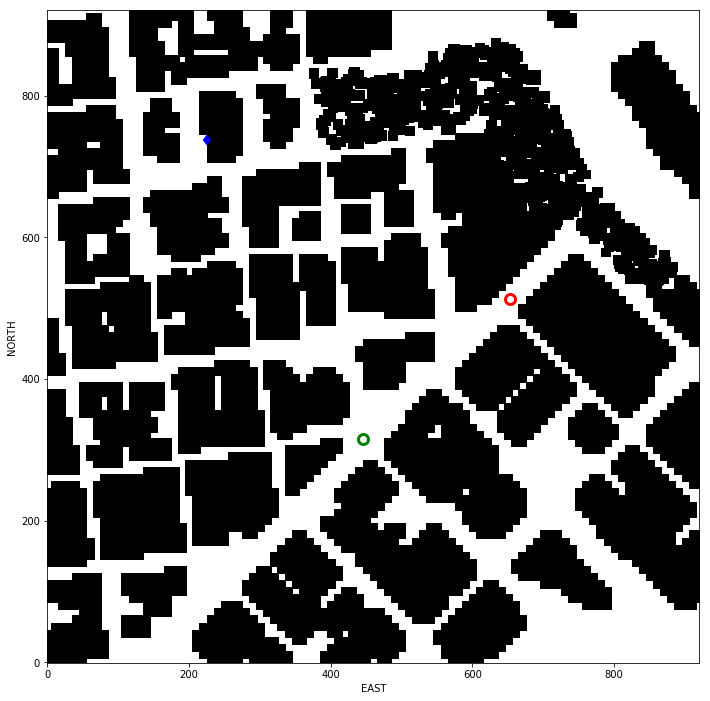

# Vertices: 2 / 4000 # Edges: 1 t: 0.0957956314086914
# Vertices: 6 / 4000 # Edges: 5 t: 0.5546820163726807
# Vertices: 10 / 4000 # Edges: 9 t: 1.1051316261291504
# Vertices: 18 / 4000 # Edges: 17 t: 2.1812872886657715
# Vertices: 27 / 4000 # Edges: 26 t: 3.7256228923797607
# Vertices: 40 / 4000 # Edges: 39 t: 6.305521011352539
# Vertices: 61 / 4000 # Edges: 60 t: 10.4168221950531
# Vertices: 95 / 4000 # Edges: 94 t: 19.380662441253662
# Vertices: 151 / 4000 # Edges: 150 t: 31.895668506622314
# Vertices: 315 / 4000 # Edges: 314 t: 58.92869448661804
# Vertices: 600 / 4000 # Edges: 599 t: 135.1355926990509
END # Vertices: 1484 / 4000 # Edges: 1483 t: 323.18292236328125
can reach from (514.064113169904, 651.9941595612561) to (513, 653); u:2.3843387655790362, dt:8, tx:-1.4642581147378506, ty:1.46425811473785, dx:1.064113169903976, dy:1.0058404387439168


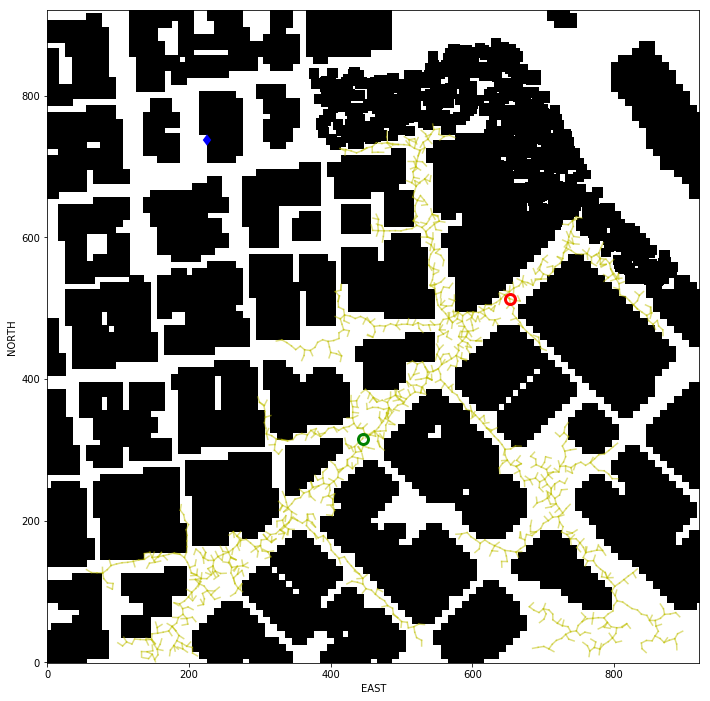

#Nodes:2, #Actions:0, Cost:287.30, HCost:279.30, Currenct Node:(323.4812000156441, 447.834015936075), Time:0.00
#Nodes:4, #Actions:0, Cost:570.45, HCost:275.14, Currenct Node:(321.3789672070732, 455.55286411560076), Time:0.00
#Nodes:8, #Actions:0, Cost:846.88, HCost:267.79, Currenct Node:(336.723075890767, 451.40953803661375), Time:0.00
#Nodes:16, #Actions:0, Cost:1121.47, HCost:267.80, Currenct Node:(320.0860938473811, 467.2527975728884), Time:0.01
#Nodes:32, #Actions:0, Cost:1542.61, HCost:298.38, Currenct Node:(304.9013078640862, 439.1593068476438), Time:0.01
#Nodes:64, #Actions:0, Cost:2057.30, HCost:296.21, Currenct Node:(325.6603702535245, 423.55819630807804), Time:0.02
#Nodes:128, #Actions:0, Cost:3374.43, HCost:250.36, Currenct Node:(365.5470891539923, 450.6731105252102), Time:0.03
#Nodes:256, #Actions:0, Cost:5803.76, HCost:74.29, Currenct Node:(467.02666256563504, 594.6404975180934), Time:0.06
Found a path.
#Nodes:338, #Actions:0, Cost:6443.19, HCost:0.00, Currenct Node:(513,

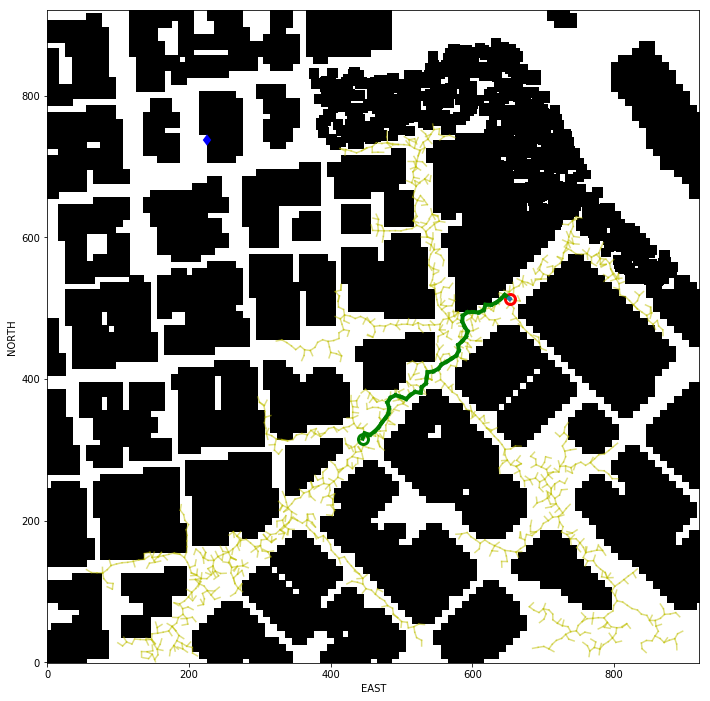

Pruned Path length:  45


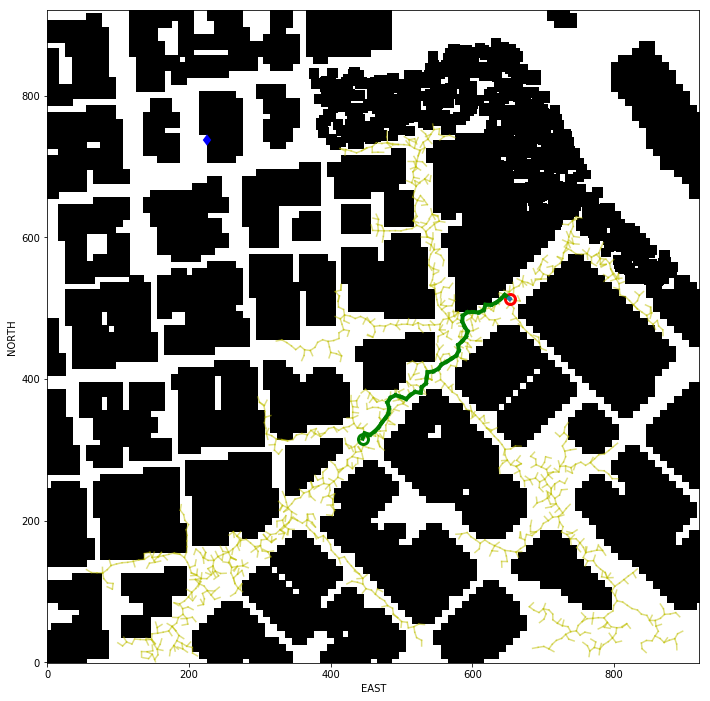

Sending waypoints to simulator ...
Closing connection ...
GRD = drone.GRD, not none


In [15]:
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5

    self.target_position[2] = TARGET_ALTITUDE

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    if self.GRD is None:
        print("creating grid")
        self.GRD = GridRRT(TARGET_ALTITUDE, SAFETY_DISTANCE)
    else:
        print("grid was already created")
        
    grid = self.GRD.grid
    north_offset = self.GRD.north_offset
    east_offset = self.GRD.east_offset
    lon0 = self.GRD.lon0
    lat0 = self.GRD.lat0

    # TODO: convert start position to current position rather than map center
    # TODO: set home position to (lon0, lat0, 0)
    self.set_home_position(lat0, lon0, 0)

    # TODO: retrieve current global position
    # TODO: convert to current local position using global_to_local()
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    north, east, att = local_pos
    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("Grid Start: ",grid_start)
    
    # Set goal as some arbitrary position on the grid
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    grid_shape = grid.shape
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_home[0] + change[0] / dist_idx,
                self.global_home[1] + change[1] / (dist_idx),
                self.global_home[2] + change[2] * 10.0)
        print("Goal Global: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("Goal Local: ", local_goal)
        ng, eg, ag = local_goal

        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))

        print(grid_goal[1], grid_shape[1] - 1)
        if grid_goal[0] >= grid_shape[0]:
            grid_goal = (grid_shape[0] - 1, grid_goal[1])
        elif grid_goal[0] < 0:
            grid_goal = (0, grid_goal[1])            
        if grid_goal[1] >= grid_shape[1]:
            grid_goal = (grid_goal[0], grid_shape[1] - 1)
        elif grid_goal[1] < 0:
            grid_goal = (grid_goal[0], 0)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        print("Selected Grid Goal, Obstacle?: ",grid_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    print('Grid Start and Goal: ', grid_start, grid_goal) 
    n_vertices = 4000
    dt = 8
    plotrrt(grid, grid_start, grid_goal, goal_list=goal_list, path=None, edges=None)
    
    rrt = self.GRD.generate_RRT(grid_start, grid_goal, n_vertices, dt)
    
    plotrrt(grid, grid_start, grid_goal, goal_list=goal_list, path=None, edges=rrt.edges)

    path, cost = a_star_graph(rrt.tree, heuristic, grid_start, grid_goal)
    print("Path length:", len(path)," cost:", cost)

    plotrrt(grid, grid_start, grid_goal, goal_list=goal_list, path=path, edges=rrt.edges)
    
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!    
    pruned_path = prune_path(path)
    print("Pruned Path length: ", len(pruned_path))
    plotrrt(grid, grid_start, grid_goal, goal_list=goal_list, path=path, edges=rrt.edges)
    
    # print("A* path:")
    # for p in path:
    #     print(p)
        
    # print("Pruned_path:")
    # for p in pruned_path:
    #     print(p)

    # Convert path to waypoints
    waypoints = [[int(np.rint(p[0] + north_offset)), int(np.rint(p[1] + east_offset)), TARGET_ALTITUDE, 0] for p in pruned_path]

    # Set self.waypoints
    self.waypoints = waypoints
    self.GRD.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
GRD = main(GRD)

In [16]:
# send waypoints directly
def plan_path_send_wp(self):
    self.flight_state = States.PLANNING

    if self.GRD is not None:
        if self.GRD.waypoints is not None:
            waypoints = self.GRD.waypoints
    
    print("waypoints")
    print(waypoints)
    for w in waypoints:
        print(w)
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path_send_wp
GRD = main(GRD)
MotionPlanning.plan_path = plan_path

main
GRD is not None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
waypoints
[[0, 0, 5, 0], [7, 3, 5, 0], [5, 11, 5, 0], [10, 17, 5, 0], [16, 23, 5, 0], [22, 27, 5, 0], [29, 32, 5, 0], [35, 36, 5, 0], [43, 37, 5, 0], [51, 35, 5, 0], [58, 39, 5, 0], [61, 47, 5, 0], [59, 54, 5, 0], [56, 62, 5, 0], [62, 67, 5, 0], [66, 74, 5, 0], [65, 82, 5, 0], [73, 84, 5, 0], [78, 89, 5, 0], [86, 90, 5, 0], [94, 92, 5, 0], [95, 100, 5, 0], [99, 107, 5, 0], [105, 112, 5, 0], [109, 119, 5, 0], [113, 125, 5, 0], [117, 132, 5, 0], [124, 136, 5, 0], [132, 135, 5, 0], [138, 141, 5, 0], [144, 146, 5, 0], [152, 148, 5, 0], [158, 144, 5, 0], [166, 141, 5, 0], [174, 141, 5, 0], [178, 148, 5, 0], [179, 156, 5, 0], [178, 164, 5, 0], [181, 171, 5, 0], [189, 174, 5, 0], [189, 182, 5, 0], [192, 189, 5, 0], [197, 195, 5, 0], [203, 201, 5, 0], [198, 207, 5, 0]]
[0, 0, 5, 0]
[7, 3, 5, 0]
[5, 11, 5, 0]
[10, 17, 5, 0]
[16, 23, 5, 0]
[22, 27, 5, 0]
[29, 32, 5, 0]
[35, 36, 5, 0]
[43, 37, 5, 0]
[51, 35, 

main
GRD is not None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3951224   37.7942553    0.151    ], local position [ 1.97202271e+02  2.07186157e+02 -1.54896468e-01]
grid was already created
Grid Start:  (514, 649)
change [ 0.07829824 -0.40946896 -0.49393982]
Goal Global:  (-122.39667031762049, 37.78838571040191, -4.939398243044156)
Goal Local:  [-453.85986515   71.8695278     4.93939824]
517 920
Selected Grid Goal, Obstacle?:  (0, 517) 0.0
Grid Start and Goal:  (514, 649) (0, 517)


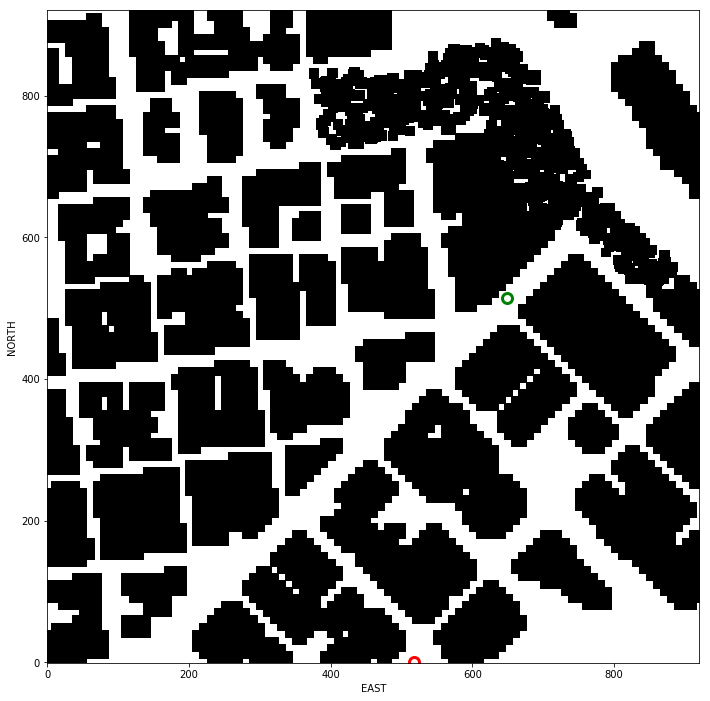

# Vertices: 2 / 4000 # Edges: 1 t: 0.0491945743560791
# Vertices: 6 / 4000 # Edges: 5 t: 0.26306843757629395
# Vertices: 8 / 4000 # Edges: 7 t: 0.4366168975830078
# Vertices: 10 / 4000 # Edges: 9 t: 0.7489759922027588
# Vertices: 13 / 4000 # Edges: 12 t: 1.5732786655426025
# Vertices: 24 / 4000 # Edges: 23 t: 3.743946075439453
# Vertices: 62 / 4000 # Edges: 61 t: 6.9905846118927
# Vertices: 130 / 4000 # Edges: 129 t: 13.980276346206665
# Vertices: 250 / 4000 # Edges: 249 t: 28.127739667892456
# Vertices: 478 / 4000 # Edges: 477 t: 66.38330554962158
# Vertices: 1005 / 4000 # Edges: 1004 t: 144.46211981773376
END # Vertices: 2323 / 4000 # Edges: 2322 t: 354.180695772171
can reach from (23.530953111382512, 518.4198865161658) to (0, 517); u:-3.08132450526772, dt:8, tx:-23.573753032745373, ty:-23.573753032745373, dx:23.530953111382512, dy:1.419886516165775


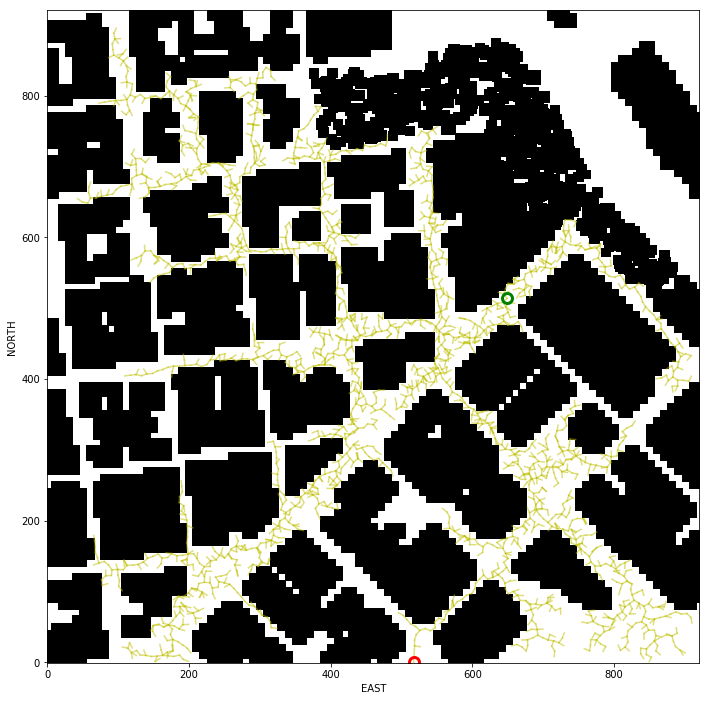

#Nodes:2, #Actions:0, Cost:532.01, HCost:524.01, Currenct Node:(508.61860502461496, 643.0804908886885), Time:0.00
#Nodes:4, #Actions:0, Cost:1058.40, HCost:518.39, Currenct Node:(501.7667530388837, 647.2099126842465), Time:0.00
#Nodes:8, #Actions:0, Cost:1095.72, HCost:543.84, Currenct Node:(528.0828282235359, 646.9806966624626), Time:0.00
#Nodes:16, #Actions:0, Cost:2092.38, HCost:505.84, Currenct Node:(487.0661074963078, 653.5235185749574), Time:0.00
#Nodes:32, #Actions:0, Cost:3099.71, HCost:492.50, Currenct Node:(477.49213750284105, 637.6660304667138), Time:0.00
#Nodes:64, #Actions:0, Cost:5069.30, HCost:483.23, Currenct Node:(474.05950361441694, 610.6815493818133), Time:0.01
#Nodes:128, #Actions:0, Cost:8370.68, HCost:464.56, Currenct Node:(462.6337228315158, 559.2559692860322), Time:0.02
#Nodes:256, #Actions:0, Cost:13231.15, HCost:473.51, Currenct Node:(472.839462875603, 491.7923478884819), Time:0.03
#Nodes:512, #Actions:0, Cost:20714.97, HCost:446.73, Currenct Node:(428.9680724

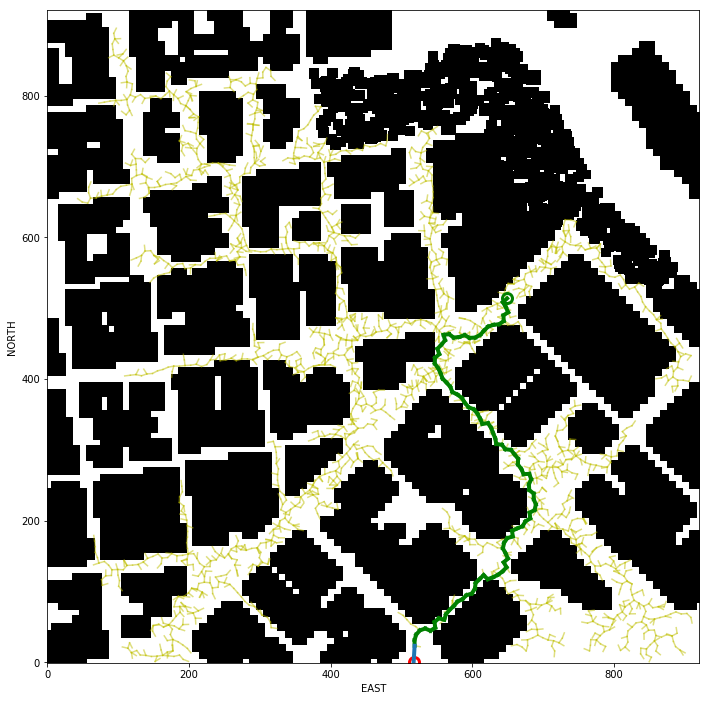

Pruned Path length:  98


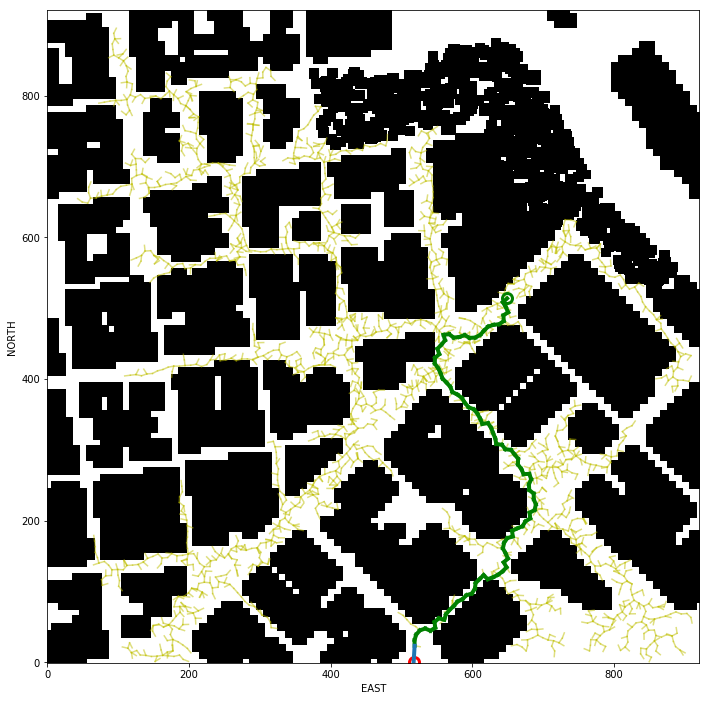

Sending waypoints to simulator ...
Closing connection ...
GRD = drone.GRD, not none


In [17]:
GRD = main(GRD)

In [ ]:
MotionPlanning.plan_path = plan_path_send_wp
GRD = main(GRD)
MotionPlanning.plan_path = plan_path

main
GRD is not None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
waypoints
[[198, 204, 5, 0], [193, 198, 5, 0], [186, 202, 5, 0], [178, 205, 5, 0], [174, 199, 5, 0], [166, 199, 5, 0], [161, 193, 5, 0], [161, 185, 5, 0], [158, 177, 5, 0], [152, 171, 5, 0], [147, 166, 5, 0], [143, 159, 5, 0], [142, 151, 5, 0], [146, 144, 5, 0], [144, 137, 5, 0], [143, 129, 5, 0], [148, 122, 5, 0], [147, 114, 5, 0], [139, 116, 5, 0], [133, 111, 5, 0], [127, 106, 5, 0], [119, 108, 5, 0], [114, 102, 5, 0], [106, 102, 5, 0], [100, 107, 5, 0], [92, 110, 5, 0], [85, 113, 5, 0], [79, 118, 5, 0], [73, 124, 5, 0], [66, 127, 5, 0], [62, 134, 5, 0], [57, 140, 5, 0], [50, 144, 5, 0], [44, 150, 5, 0], [41, 157, 5, 0], [35, 162, 5, 0], [28, 166, 5, 0], [21, 169, 5, 0], [22, 177, 5, 0], [15, 181, 5, 0], [8, 184, 5, 0], [0, 187, 5, 0], [-8, 189, 5, 0], [-9, 197, 5, 0], [-15, 202, 5, 0], [-16, 210, 5, 0], [-22, 214, 5, 0], [-28, 220, 5, 0], [-36, 219, 5, 0], [-43, 224, 5, 0], [-50, 227, 5, 0], [-5